# NLP Launch: Natural Language Predictor Project

<div class="alert alert-success">  
    
## Goals: 
    
* The project goal is to predict which programming language is used based solely on GitHub README's. 
* This analysis aims to address the listed questions and uncover any additional important findings related goal.
</div>

# `Imports`

In [1]:
#.py modules
import acquire as ac
import prepare as pp
import explore as ex
import evaluate as ev

#standard
import pandas as pd
import numpy as np
import re

#scraping
import requests
from requests import get
from bs4 import BeautifulSoup

#file
import os
import json

#vizz
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#preprocess
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#split and model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#set random state
random_state=123

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

json file found and loaded
imports loaded successfully, awaiting commands...


# `Acquire`

### Acquire
* Data acquired from GitHub using Selenium
    * env.py credentials used to access GitHub
* 740 rows × 1 column before cleaning
* 740 rows × 3 columns after cleaning and acquiring READMEs


### Data Dictionary

| Feature | Definition|
|:--------|:-----------|
|repo| The 'author name/repo name' of the repo|
|language| The repo language used|
|readme| The cleaned contents of unqiue READMEs|

In [2]:
#get repo authors and names
click_data = ac.button_click()

json file found and loaded


In [3]:
#quick peek
click_data.head()

,string
0,sindresorhus / awesome
1,vinta / awesome-python
2,awesome-selfhosted / awesome-selfhosted
3,avelino / awesome-go
4,trimstray / the-book-of-secret-knowledge


In [4]:
#get readme contents and add to click_data
scraped = ac.get_scraped_data()

json file found and loaded


In [5]:
#quick peek
scraped.head()

,repo,language,readme_contents
0,sindresorhus/awesome,None,"<div align=""center"">\n\t<a href=""https://vshym..."
1,vinta/awesome-python,Python,# Awesome Python [![Awesome](https://cdn.rawgi...
2,awesome-selfhosted/awesome-selfhosted,Makefile,# Awesome-Selfhosted\n\n[![Awesome](https://cd...
3,avelino/awesome-go,Go,"# Awesome Go\n\n<a href=""https://awesome-go.co..."
4,trimstray/the-book-of-secret-knowledge,None,"<p align=""center"">\n <a href=""https://github...."


<div class="alert alert-success">    

### Insight: 
    
Two dataframes were pulled back. 
    <br>
* The first df was created using Selenium to scrape for repo author/repo names. Selenium was used to prevent duplication of repos by loading the entire page requested and then scraping versus having to refresh after each page selection.
    <br>
* The second df was created using the return of the the first df by plugging in the scraped repo author/repo names into the acquire.py function to scrape each README associated with that unique identifier.
</div>

# `Prepare`

### Prepare
* No duplicates
* No nulls
* Changed languages that are not 'Python', 'JavaScript', 'HTML', 'Shell', 'Java', or 'Go' to 'other'
    * other = 599
* Cleaned all text using
    * prepare.py functions
* Additional Stopwords used to account for all word fractions leftover from the cleaning process to get as close as possible to all true words
* No outliers removed

In [6]:
#clean
df = pp.clean_df(scraped, 'readme_contents')

In [7]:
#quick peek
df.head()

,repo,language,readme
0,sindresorhus/awesome,other,div align center href http vshymanskyy standwi...
1,vinta/awesome-python,python,awesome python awesome http cdn rawgit sindres...
2,awesome-selfhosted/awesome-selfhosted,other,awesome selfhosted awesome http cdn jsdelivr n...
3,avelino/awesome-go,go,awesome go href http awesome go img align righ...
4,trimstray/the-book-of-secret-knowledge,other,p align center href http trimstray book secret...


In [8]:
#creating a df of all the words and their associated languages and filtering out as much gibberish as possible without limiting the data
word_counts = ex.get_words(df)

Unfiltered Data:187422 words  Filtered Data: 4000 words



In [9]:
#quick peek
word_counts.head()

,all,python,javascript,html,shell,java,go,other
http,216403,13261,11087,5400,6164,2811,4422,173258
img,22653,2659,1573,112,268,1171,131,16739
code,14546,1457,534,242,198,209,276,11630
awesome,13657,412,926,309,369,43,113,11485
source,12573,408,783,217,146,121,107,10791


In [10]:
#make a list called keep_words
keep_words = word_counts.index.tolist()

In [11]:
def clean_readme(string):
    '''
    this function is meant to clean the original readmes in the df to filter out as much gibberish as possible
    '''
    words = string.split()
    clean_words = [word for word in words if word in keep_words]
    clean_words = ' '.join(clean_words)
    return clean_words

In [12]:
#applying cleaning to the readmes
df.readme = df.readme.apply(clean_readme)

<div class="alert alert-success">    

### Insight: 
    
Prepare involved creating a single df from both dfs to start the explore phase.
    <br>
* We changed the python languages that had less than 10 occurences to 'other' in order to bin our target variable into more managable items.
* We added 4,000 unqiue words to a list in order to keep those words in the READMEs and to filter out some of the nonsense to get down as close as possible to actual words.
</div>

# `Explore`

### Questions To Answer:
1. What are the most common words in READMEs?
2. Does the length of the README vary by programming language?
3. Do different programming languages use a different number of unique words?
4. Are there any words that uniquely identify a programming language?

## Counts and Frequencies

In [13]:
#counts and frequencies of languages
freq = ex.show_counts_and_ratios(df, 'language')

In [14]:
#quick peek
freq

,n,percent
other,599,0.81
python,40,0.05
javascript,36,0.05
html,25,0.03
shell,19,0.03
java,11,0.01
go,10,0.01


<div class="alert alert-success">    

### Insight: 
    
'Other' accounts for 81% of languages in the READMEs pulled. This will become our baseline for the classification modeling phase.
</div>

## 1. What are the most common words in READMEs?

In [15]:
#look at the top 20 words
word_counts['all'].sort_values(ascending=False).head(20)

http       216403
img         22653
code        14546
awesome     13657
source      12573
star        12353
data        11898
web         11368
tool        11035
library     11006
href        10385
shield      10256
open         9669
go           9634
svg          9286
html         8824
style        8661
badge        8569
python       8293
image        8176
Name: all, dtype: int64

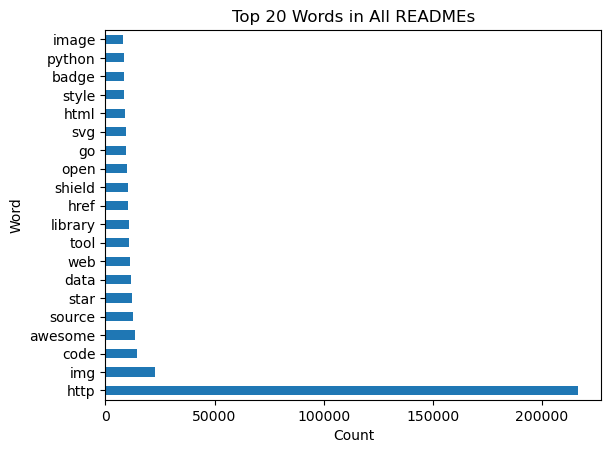

In [16]:
#visualize the top 20 words
word_counts['all'].sort_values(ascending=False).head(20).plot.barh()
plt.title('Top 20 Words in All READMEs')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

<div class="alert alert-success">    

### Insight: 
    
By cleaning the READMEs we were able to identify the top 20 actual words across all READMEs.
    <br>
* http is the highest, with more time we would also remove that word during cleaning to be able to interpret the other words better as it is an outlier.
</div>

## 2. Does the length of the README vary by programming language?

$H_0$: The length of the readme does not vary by programming language


$H_a$: The programing language does vary by programming language

            letter_count
language                
go          31439.300000
html        18751.880000
java        25847.727273
javascript  21978.527778
other       21532.151920
python      22612.525000
shell       21328.421053


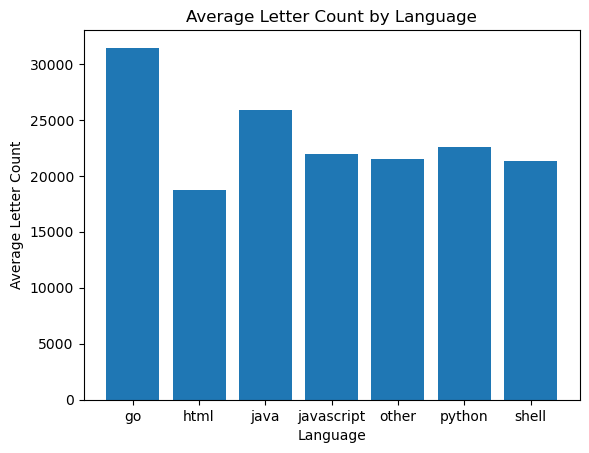

Levene Test Successful
p-value = nan. There is no significant difference between the means of language and letter_count.


In [17]:
#visualize the lengths of readmes against labels
ex.calculate_average_letter_count(df)

<div class="alert alert-success">    

### Insight: 
     
The average length of readmes by language varied but not significanly so, except for Go.
    <br>
</div>

## 3. Do different programming languages use a different number of unique words?

In [18]:
#look at the number of unique words per language
word_counts.drop(columns={'all', 'other'}).nunique()

python        272
javascript    257
html          187
shell         180
java          125
go            146
dtype: int64

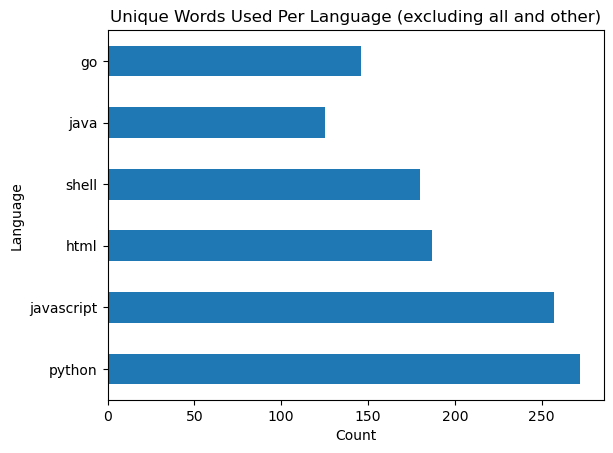

In [19]:
#visualize number of unique words per label
word_counts.drop(columns={'all', 'other'}).nunique().plot.barh()
plt.title('Unique Words Used Per Language (excluding all and other)')
plt.xlabel('Count')
plt.ylabel('Language')
plt.show()

In [20]:
#analyze?


<div class="alert alert-success">    

### Insight: 
    
When looking at the unique words per language we excluded the 'all' and 'other' columns and looked solely at explicitly defined languages.
    <br>
* As you can see the number of unqiue words per langugage is slightly different.
* With Python being the highest and Java having the least amount.
</div>

## 4. Are there any words that uniquely identify a programming language?

In [21]:
#look at the frequency of unique words per language
word_counts.sort_values('go', ascending=False).head(20).apply(lambda row: row/row['all'], axis=1).round(2)

,all,python,javascript,html,shell,java,go,other
http,1.0,0.06,0.05,0.02,0.03,0.01,0.02,0.80
go,1.0,0.01,0.01,0.01,0.01,0.00,0.37,0.59
golang,1.0,0.01,0.01,0.02,0.01,0.00,0.40,0.55
library,1.0,0.07,0.03,0.03,0.01,0.02,0.05,0.80
career,1.0,0.03,0.05,0.00,0.00,0.00,0.49,0.43
tool,1.0,0.04,0.10,0.03,0.04,0.01,0.03,0.74
package,1.0,0.02,0.03,0.02,0.01,0.00,0.05,0.87
page,1.0,0.06,0.07,0.02,0.01,0.00,0.09,0.74
code,1.0,0.10,0.04,0.02,0.01,0.01,0.02,0.80
content,1.0,0.05,0.03,0.02,0.01,0.01,0.06,0.83


In [22]:
#another way to look at it using counts
word_counts.sort_values('go', ascending=False).head(20) # use a list to sort by more than one column!

,all,python,javascript,html,shell,java,go,other
http,216403,13261,11087,5400,6164,2811,4422,173258
go,9634,75,107,119,49,12,3563,5709
golang,1409,17,17,24,16,0,561,774
library,11006,752,381,319,64,219,518,8753
career,818,21,39,4,2,0,399,353
tool,11035,415,1153,338,478,78,360,8213
package,6007,148,171,101,65,10,303,5209
page,3195,193,217,67,37,7,299,2375
code,14546,1457,534,242,198,209,276,11630
content,4597,220,136,101,43,25,274,3798


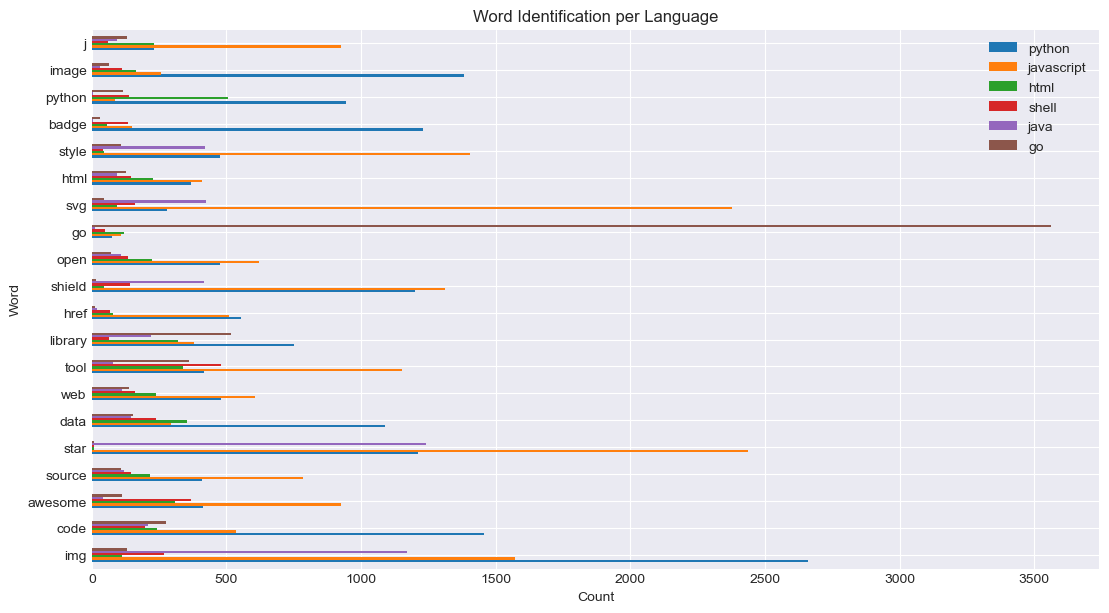

In [23]:
#visualizing the top 20 words sorted on all but only displaying the ham and spam columns
ex.unique_words(word_counts)

<div class="alert alert-success">    

### Insight: 
    
**Note: The graph has excluded http as a word in order to visualize the other words better as http is an outlier**
    
The frequency of certain words does look like it can relate to specific languages. The above lists are sorted on the language 'go' and are only the top 20.
    <br>
* Python contains library and api
* JavaScript contains tool and file
* HTML contains file and code
* Shell contains tool and file
* Java contains library and code
* Go contains go, golang, and library
    <br>

Given more time, I would sort each column and make note of each languages top 20 words and would compare those against all findings.
</div>

# `Preprocessing`

In [24]:
#make the count vectorizer thing to create the bag of words to prepare for modeling
bag_of_words = ev.make_bag_o_words(df, 'readme')

In [25]:
#splitting the data
train, validate, test = ev.split_data_strat(df, 'language')

Prepared DF: (740, 4)
Train: (444, 4)
Validate: (148, 4)
Test: (148, 4)


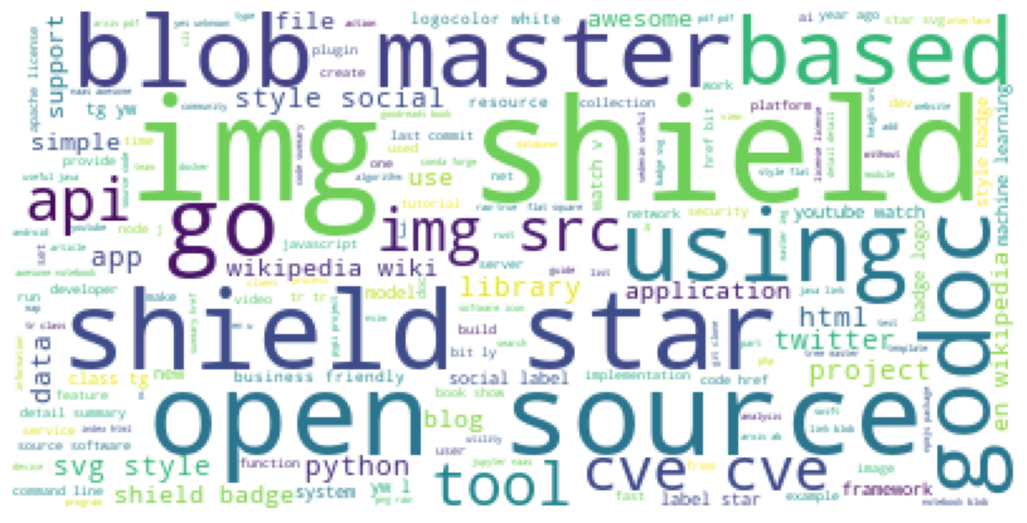

In [26]:
#train wordcloud
img = WordCloud(background_color='white').generate(' '.join(train.readme))
plt.imshow(img)
plt.axis('off')
plt.show()

In [27]:
#setting the baseline
train['baseline_prediction'] = 'other'

baseline_accuracy = (train.baseline_prediction == train.language).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 80.86%


In [28]:
#assign variables
X_train, y_train, X_validate, y_validate, X_test, y_test = ev.assign_variables(train, validate, test)

In [29]:
#make my bag of words
X_bow, X_validate_bow, X_test_bow = ev.make_variable_bag_o_words(X_train, X_validate, X_test)

# `Modeling`

In [30]:
ev.model_one(X_bow, y_train, X_validate_bow, y_validate)

Decision Tree / Max Depth = 3: `train` accuracy: 83.00%
Decision Tree / Max Depth = 3: `validate` accuracy: 80.00%


In [31]:
ev.model_two(X_bow, y_train, X_validate_bow, y_validate)

KNN / Neighbors = 5: `train` accuracy: 82.00%
KNN / Neighbors = 5: `validate` accuracy: 79.00%


In [32]:
ev.model_three(X_bow, y_train, X_validate_bow, y_validate)

KNN / Neighbors = 9: `train` accuracy: 82.00%
KNN / Neighbors = 9: `validate` accuracy: 82.00%


## TEST

In [33]:
ev.test_model(X_bow, y_train, X_test_bow, y_test)

baseline accuracy: 80.68%
KNN / Neighbors = 9: `test` accuracy: 82.00%


# `Conclusion`

<div class="alert alert-success">    
 
### Explore: 
    
---
    
We asked the following questions:
<br>
1. What are the most common words in READMEs?
2. Does the length of the README vary by programming language?
3. Do different programming languages use a different number of unique words?
4. Are there any words that uniquely identify a programming language?
<br>
    
The discoveries are as follows:
<br>
1. http is the highest, with more time we would also remove that word during cleaning to be able to interpret the other words better as it is an outlier.
    * img came in as the second highest word
    * The rest of the top 20 words: code, awesome, source, star, data, web, tool, library, href, shield, open, go, svg, html, style, badge, python, image
  
    <br>
    
2. The average length of readmes by language varied but not significanly.
    * Go seemed to have a spike though, but not significant.
    
<br>   
    
3. The number of unqiue words per langugage is only slightly different.
    * Python has the highest with 272
    * Java has the least with 125.

    <br>  
4. The frequency of certain words does look like it can relate to specific languages. 
**note: our exploration was sorted on the language 'go' and only pulled the top 20.**
    * Python contains library and api
    * JavaScript contains tool and file
    * HTML contains file and code
    * Shell contains tool and file
    * Java contains library and code
    * Go contains go, golang, and library
<br>
    
---

### Modeling: 
    
---
    
Models Selected: 
    
**Baseline: 80.86%**
    
* Decision Tree
    * Depth of 3
        * Train Accuracy: 82.66%
        * Validate Accuracy: 79.73%

    <br>
    
* KNN 
    * Neighbors of 5
        * Train Accuracy: 82.21%
        * Validate Accuracy: 79.05%
    * Neighbors of 9
        * Train Accuracy: 81.53%
        * Validate Accuracy: 82.43%

* KNN, n=9 chosen for test because it was the only model that didn't fail on validate:
    * **Test Accuracy: 81.76%**

---   
</div>

# `Recommendations/Next Steps`

<div class="alert alert-success">   
    
We would create a column identifying the likely subject of each repo. Create a feature on github where individuals have to identify the subject that their project is looking into. This may User Experience and Interface engineers.
    
</div>    